In [10]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset

# Verificar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Función para preprocesar texto
def preprocess_text(text_series):
    text_series = text_series.str.replace(r'http\S+', '', regex=True)  # Eliminar URLs
    text_series = text_series.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Eliminar caracteres especiales
    return text_series.str.lower().str.strip()

# Cargar datasets
train_data = pd.read_csv("divisonDatos/train_data.csv", sep=";")
val_data = pd.read_csv("divisonDatos/val_data.csv", sep=";")
test_data = pd.read_csv("divisonDatos/test_data.csv", sep=";")
train_data

Usando dispositivo: cuda


,Label,Texto
0,0,rita maestre anuncia que en agosto llegarán 34...
1,0,psoe aclara que la mesa de negociación debe se...
2,0,campaña por la educación nueva propuesta legis...
3,1,educación y formación profesional destina más ...
4,1,la resurrección del presupuesto de andalucía y...
...,...,...
51988,0,nueva fórmula de alfonso guerra contra los par...
51989,0,el ministerio de sanidad lanza una campaña par...
51990,0,feijóo ensaya para las generales y moreno se s...
51991,0,el ministerio de educación anuncia nuevas medi...


Epoch 0/2000, Loss: 0.6923, Val Loss: 0.6915
Epoch 10/2000, Loss: 0.6727, Val Loss: 0.6749
Epoch 20/2000, Loss: 0.6550, Val Loss: 0.6603
Epoch 30/2000, Loss: 0.6391, Val Loss: 0.6470
Epoch 40/2000, Loss: 0.6243, Val Loss: 0.6350
Epoch 50/2000, Loss: 0.6107, Val Loss: 0.6240
Epoch 60/2000, Loss: 0.5980, Val Loss: 0.6139
Epoch 70/2000, Loss: 0.5864, Val Loss: 0.6047
Epoch 80/2000, Loss: 0.5761, Val Loss: 0.5963
Epoch 90/2000, Loss: 0.5658, Val Loss: 0.5886
Epoch 100/2000, Loss: 0.5561, Val Loss: 0.5815
Epoch 110/2000, Loss: 0.5477, Val Loss: 0.5750
Epoch 120/2000, Loss: 0.5399, Val Loss: 0.5690
Epoch 130/2000, Loss: 0.5321, Val Loss: 0.5635
Epoch 140/2000, Loss: 0.5254, Val Loss: 0.5584
Epoch 150/2000, Loss: 0.5186, Val Loss: 0.5537
Epoch 160/2000, Loss: 0.5121, Val Loss: 0.5494
Epoch 170/2000, Loss: 0.5070, Val Loss: 0.5455
Epoch 180/2000, Loss: 0.5006, Val Loss: 0.5418
Epoch 190/2000, Loss: 0.4960, Val Loss: 0.5384
Epoch 200/2000, Loss: 0.4908, Val Loss: 0.5353
Epoch 210/2000, Loss: 0.

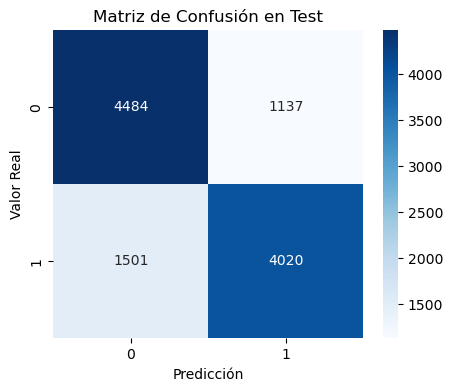

In [12]:
import numpy as np
import torch
import torch.nn as nn
# import torch.optim as optim  # Ya no usaremos Adam de esta librería, pero lo podrías dejar si gustas
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de definir o importar preprocess_text, por ejemplo:
# def preprocess_text(series):
#     # Aquí pones tu lógica de preprocesado (eliminar stopwords, minúsculas, etc.)
#     return series

# Reemplaza device con "cpu" si no cuentas con CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ===========================
#  Implementación manual ADAM
# ===========================
class ManualAdam:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.params = list(params)  # parámetros del modelo
        self.lr = lr
        self.betas = betas
        self.eps = eps

        # Listas para almacenar las estimaciones de primer y segundo momento
        self.m = [torch.zeros_like(p.data) for p in self.params]
        self.v = [torch.zeros_like(p.data) for p in self.params]

        # Contador de pasos (epochs * iteraciones)
        self.t = 0

    def zero_grad(self):
        """
        Pone en cero todos los gradientes de los parámetros.
        """
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        """
        Actualiza cada parámetro según la regla de ADAM.
        """
        self.t += 1
        b1, b2 = self.betas

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            g = param.grad.data  # gradiente

            # Actualizar estimaciones de primer y segundo momento
            self.m[i] = b1 * self.m[i] + (1 - b1) * g
            self.v[i] = b2 * self.v[i] + (1 - b2) * (g * g)

            # Corrección por sesgo
            m_hat = self.m[i] / (1 - b1 ** self.t)
            v_hat = self.v[i] / (1 - b2 ** self.t)

            # Actualización del parámetro
            param.data = param.data - self.lr * (m_hat / (torch.sqrt(v_hat) + self.eps))


# =============================================================================
#     DATAFRAMES Y PREPROCESAMIENTO
# =============================================================================
# Supongamos que train_data, val_data, test_data son DataFrames con columnas ["Texto", "Label"].

# Renombra los DataFrames para no sobrescribir:
df_train = train_data.copy()
df_val = val_data.copy()
df_test = test_data.copy()

# Preprocesar texto en DataFrames
df_train['Texto'] = preprocess_text(df_train['Texto'])
df_val['Texto'] = preprocess_text(df_val['Texto'])
df_test['Texto'] = preprocess_text(df_test['Texto'])

# Convertir texto a vectores numéricos usando TF-IDF
vectorizer = TfidfVectorizer(max_features=20000)
X_train = vectorizer.fit_transform(df_train['Texto']).toarray()
X_val = vectorizer.transform(df_val['Texto']).toarray()
X_test = vectorizer.transform(df_test['Texto']).toarray()

y_train = df_train['Label'].values
y_val = df_val['Label'].values
y_test = df_test['Label'].values

# Calcular pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Crear TensorDatasets (ya no sobreescribimos df_train, df_val, df_test)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Crear DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# =============================================================================
#     MODELO DE REGRESIÓN LOGÍSTICA
# =============================================================================
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# Inicializar modelo
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim).to(device)

# Inicializar pesos del modelo
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# Definir función de pérdida
criterion = nn.BCELoss(reduction='none')  # sin reducción para luego aplicar pesos

# Definir nuestro optimizador manual ADAM
# optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Versión de PyTorch
optimizer = ManualAdam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-8)


# =============================================================================
#     EARLY STOPPING
# =============================================================================
class EarlyStopping:
    def __init__(self, patience=20, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True
        return self.stop_training


# =============================================================================
#     FUNCIÓN DE ENTRENAMIENTO
# =============================================================================
def train_model(model, train_loader, criterion, optimizer, val_loader, class_weights, n_epochs=2000):
    early_stopping = EarlyStopping(patience=20, delta=0.0001)
    model.train()

    for epoch in range(n_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)

            # Aplicar pesos a la pérdida
            weights = torch.where(labels == 1, class_weights[1], class_weights[0])
            loss = (loss * weights).mean()

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validación
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                weights = torch.where(labels == 1, class_weights[1], class_weights[0])
                val_loss += (loss * weights).mean().item()

        avg_val_loss = val_loss / len(val_loader)

        if early_stopping(avg_val_loss):
            print(f"Early stopping en la época {epoch}")
            break

        if epoch % 10 == 0:
            avg_train_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch}/{n_epochs}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        model.train()  # volver a modo entrenamiento


# =============================================================================
#     ENTRENAR EL MODELO
# =============================================================================
train_model(model, train_loader, criterion, optimizer, val_loader, class_weights, n_epochs=2000)


# =============================================================================
#     EVALUACIÓN DEL MODELO + MATRIZ DE CONFUSIÓN
# =============================================================================
def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs >= threshold).float()
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    y_pred = np.array(y_pred).flatten()
    y_true = np.array(y_true).flatten()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    return acc, f1, precision, recall, y_pred, y_true


# Ajustar umbral dinámicamente en validación
thresholds = np.linspace(0.1, 0.9, 100)
best_metrics = None
best_threshold = 0.5

for thr in thresholds:
    acc, f1, precision, recall, _, _ = evaluate_model(model, val_loader, threshold=thr)
    # Criterio: 0.79 <= precision <= 0.80
    if 0.79 <= precision <= 0.80:
        best_metrics = (thr, acc, f1, precision, recall)
        break

if best_metrics:
    best_threshold, acc, f1, precision, recall = best_metrics
    print(f"Mejor umbral: {best_threshold:.2f}")
    print(f"Evaluación en validación: Acc: {acc:.4f}, F1: {f1:.4f}, Precisión: {precision:.4f}, Recall: {recall:.4f}")
else:
    print("No se encontró umbral con precisión en [0.79, 0.80]. Se usará 0.5 por defecto.")


# Evaluar en test y graficar la matriz de confusión
acc, f1, precision, recall, y_pred_test, y_true_test = evaluate_model(model, test_loader, threshold=best_threshold)
print(f"Evaluación en test: Acc: {acc:.4f}, F1: {f1:.4f}, Precisión: {precision:.4f}, Recall: {recall:.4f}")

# Graficar matriz de confusión
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión en Test")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()
